In [ ]:
import pandas as pd
df = pd.read_csv(r"LLM_score.csv")
df.columns = [c.strip() for c in df.columns]

In [4]:
# Define expected criteria
CRITERIA = [
    "Content Coverage",
    "Narrative Coherence",
    "Clinical Relevance",
    "Compression Quality",
    "Experience Preservation"
]
MODELS = ["LexRank", "LSA", "SBERT"]

In [5]:
required = {"Substance", "Model", *CRITERIA}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")
else:
    print("All required columns present.")

All required columns present.


In [6]:
for col in CRITERIA:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
substances = sorted(df["Substance"].unique())
substance_data = {}

for substance in substances:
    group = df[df["Substance"] == substance].set_index("Model").reindex(MODELS)
    substance_data[substance] = group[CRITERIA].astype(float)

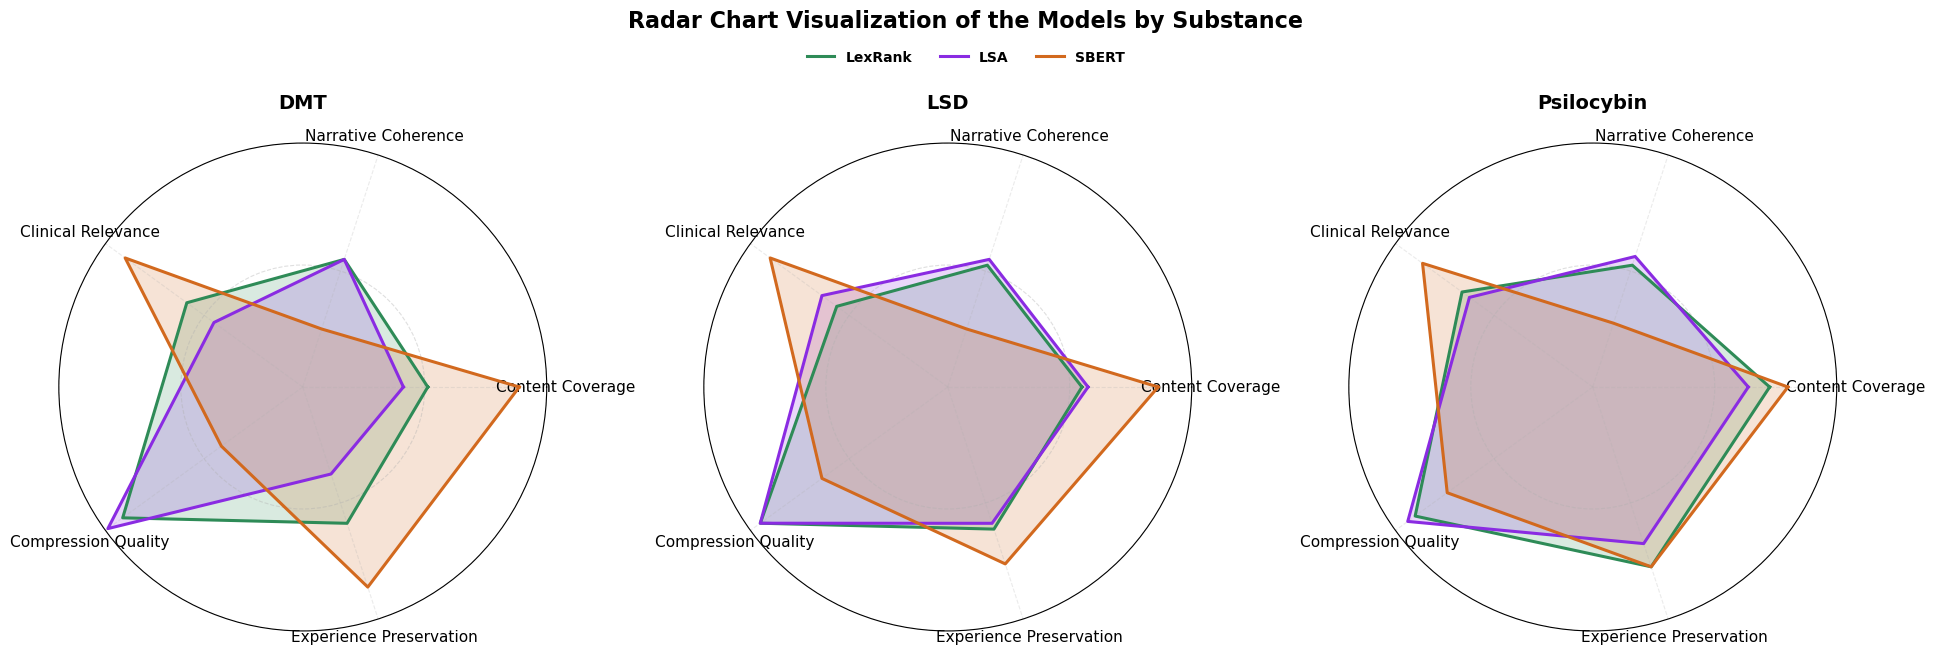

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# High-contrast, distinct colors for models
MODEL_COLORS = {
    "LexRank": "#2E8B57",   # Sea Green
    "LSA":     "#8A2BE2",   # Blue Violet
    "SBERT":   "#D2691E",   # Chocolate Orange
}

# Radar angle setup
angles = np.linspace(0, 2 * np.pi, len(CRITERIA), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# A single figure with subplots (1 row, up to 3 substances)
n_subs = len(substances)
n_cols = min(n_subs, 3)  # Max 3 per row
fig, axes = plt.subplots(1, n_cols, figsize=(6.5 * n_cols, 7), subplot_kw=dict(polar=True))

# Handle single subplot
if n_cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each substance
for idx, substance in enumerate(substances[:n_cols]): 
    ax = axes[idx]
    data = substance_data[substance]

    # Radar styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(CRITERIA, fontsize=11)
    ax.set_ylim(1, 5)
    ax.set_yticks([1, 3, 5])
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.xaxis.grid(True, linestyle="--", alpha=0.25)

    # Plot each model
    for model in MODELS:
        if model in data.index:
            values = data.loc[model].astype(float).values.tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2.2, color=MODEL_COLORS[model], label=model)
            ax.fill(angles, values, color=MODEL_COLORS[model], alpha=0.18)

    # Bold substance name
    ax.set_title(substance, fontsize=14, fontweight="bold", pad=25)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=MODEL_COLORS[model], edgecolor='k', linewidth=0.5,
                         label=f"{model}", alpha=0.18) for model in MODELS]

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=MODEL_COLORS[model], lw=2.2, label=model) for model in MODELS]

fig.legend(handles=legend_elements, loc="upper center",
           bbox_to_anchor=(0.5, 0.93), ncol=len(MODELS),
           frameon=False, fontsize=12, prop={'weight': 'bold'})


fig.suptitle("Radar Chart Visualization of the Models by Substance",
             fontsize=16, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.92])


plt.savefig("radar_chart.png", dpi=600, bbox_inches="tight")
plt.show()

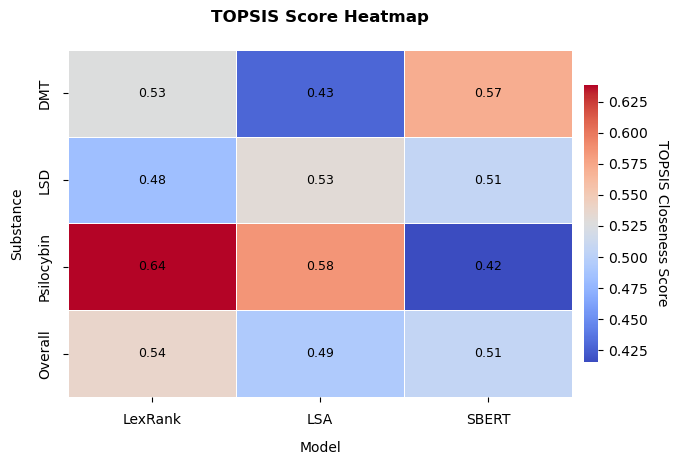

In [23]:
subs = sorted(df["Substance"].unique())
heat_topsis = np.zeros((len(subs) + 1, len(MODELS)))  # +1 for "Overall"

# Per-substance TOPSIS
for i, sub in enumerate(subs):
    g = df[df["Substance"] == sub].set_index("Model").reindex(MODELS)
    heat_topsis[i, :] = topsis(g[CRITERIA].values, weights)

# Overall TOPSIS: average scores across all substances per model
pooled = df.groupby("Model")[CRITERIA].mean().reindex(MODELS)
heat_topsis[-1, :] = topsis(pooled.values, weights)

# Row labels
row_labels_topsis = subs + ["Overall"]

# Convert to DataFrame
topsis_df = pd.DataFrame(heat_topsis, index=row_labels_topsis, columns=MODELS)

# Plot TOPSIS Heatmap with Blues and improved spacing
fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(
    topsis_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "TOPSIS Closeness Score", "pad": 0.02, "shrink": 0.8},  # pad: more space above label
    square=False,
    linewidths=0.7,
    linecolor="white",
    annot_kws={"color": "black", "weight": "regular", "fontsize": 9},
    ax=ax
)

# Title
ax.set_title("TOPSIS Score Heatmap", fontsize=12, pad=20, weight="bold")
ax.set_xlabel("Model", fontsize=10, labelpad=10)      # Space between x-label and ticks
ax.set_ylabel("Substance", fontsize=10, labelpad=10)  # Space between y-label and ticks

# Improve tick label spacing (add padding)
ax.tick_params(axis='x', which='both', pad=8)   # More space below x-tick labels
ax.tick_params(axis='y', which='both', pad=8)   # More space left of y-tick labels

# Rotate x-labels slightly if needed (optional)
plt.xticks(rotation=0, ha='center')

# Colorbar label padding
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("TOPSIS Closeness Score", rotation=270, labelpad=15)  # ← Key: increase labelpad

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Prevent title cutoff
plt.savefig("topsis_heatmap.png", dpi=600, bbox_inches="tight")
plt.show()